In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils

from astropy.io import ascii

## Grism Saturation Limits

In [3]:
# Initiate NIRCam observation
pynrc.setup_logging('WARN', verbose=False)
nrc = pynrc.NIRCam('F322W2', pupil='GRISM0', wind_mode='STRIPE', ngroup=2, ypix=64, module='A')

# Want to know K-Band limiting magnitude
bp_k = pynrc.bp_2mass('k')

# Spectral types to check
sp_A0V = pynrc.stellar_spectrum('A0V')
sp_M2V = pynrc.stellar_spectrum('M2V')

In [4]:
# F322W Saturation limits
nrc.filter = 'F322W2'
sat_F322W_A0V = nrc.sat_limits(sp_A0V, bp_k)
sat_F322W_M2V = nrc.sat_limits(sp_M2V, bp_k)

In [5]:
# F444W Saturation limits
nrc.filter = 'F444W'
sat_F444W_A0V = nrc.sat_limits(sp_A0V, bp_k)
sat_F444W_M2V = nrc.sat_limits(sp_M2V, bp_k)

In [6]:
# Wavelengths to interoplate
waves3 = np.arange(2.5,4.1,0.2) # F322W2
waves4 = np.arange(4.1,5.1,0.2) # F444W
waves = np.concatenate((waves3,waves4))

# Interpolate above results and combine
sat3 = np.interp(waves3,sat_F322W_A0V['wave'],sat_F322W_A0V['satmag'])
sat4 = np.interp(waves4,sat_F444W_A0V['wave'],sat_F444W_A0V['satmag'])
sat_A0V = np.concatenate((sat3,sat4))

sat3 = np.interp(waves3,sat_F322W_M2V['wave'],sat_F322W_M2V['satmag'])
sat4 = np.interp(waves4,sat_F444W_M2V['wave'],sat_F444W_M2V['satmag'])
sat_M2V = np.concatenate((sat3,sat4))

## Continuum Sensitivities

In [7]:
flist = ['F277W', 'F356W', 'F444W', 'F322W2', 'F430M', 'F460M']

# Zodiacal Background Rates
print('{:<8} {:<6} {:<6} {:<6} {:<6} {:<6}'.format('Filter', 'Low', 'NRC', 'Avg', 'High', 'Max'))
for filt in flist:
    nrc.filter = filt
    print('{:<8} {:<6.2f} {:<6.2f} {:<6.2f} {:<6.2f} {:<6.2f}'
        .format(nrc.filter, nrc.bg_zodi(1), nrc.bg_zodi(1.2), \
                nrc.bg_zodi(2.5), nrc.bg_zodi(5), nrc.bg_zodi(10)))

Filter   Low    NRC    Avg    High   Max   
F277W    0.13   0.15   0.32   0.63   1.26  
F356W    0.20   0.24   0.49   0.99   1.98  
F444W    0.47   0.57   1.18   2.37   4.73  
F322W2   0.34   0.40   0.84   1.68   3.36  
F430M    0.09   0.11   0.22   0.44   0.88  
F460M    0.11   0.13   0.27   0.54   1.09  


In [8]:
# Continuum sensitivity (10-sigma at 10000-sec)
#nrc.update_detectors(wind_mode='FULL', ngroup=93, nint=10, ypix=2048, verbose=True)
nrc.update_detectors(wind_mode='FULL', read_mode='DEEP8', ngroup=10, nint=5, ypix=2048, verbose=True)

nrc.filter = 'F444W'
sens_F444W = nrc.sensitivity(nsig=10, zfact=2.5)

nrc.filter='F322W2'
sens_F322W = nrc.sensitivity(nsig=10, zfact=2.5)

sen3 = np.interp(waves3,sens_F322W['wave'],sens_F322W['sensitivity'])
sen4 = np.interp(waves4,sens_F444W['wave'],sens_F444W['sensitivity'])
sen_cont = np.concatenate((sen3,sen4))

New Ramp Settings:
  read_mode :    DEEP8
  nf        :        8
  nd2       :       12
  ngroup    :       10
  nint      :        5
New Detector Settings
  wind_mode :     FULL
  xpix      :     2048
  ypix      :     2048
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :  214.735
  t_frame   :   10.737
  t_int     : 2018.513
  t_int_tot : 2029.250
  t_exp     : 10092.564
  t_acq     : 10146.253


## Grism Resolution

In [9]:
import multiprocessing as mp

webbpsf = nrc_utils.webbpsf
inst = webbpsf.NIRCam()
inst.options['output_mode'] = 'both'
inst.options['parity'] = 'even'
inst.pupilopd = None
inst.filter = nrc.filter
inst.image_mask = None
# WebbPSF doesn't know about the grisms, so set pupil=None, otherwise inst_params['pupil']
inst.pupil_mask = None

inst.SHORT_WAVELENGTH_MIN = inst.LONG_WAVELENGTH_MIN = 0
inst.SHORT_WAVELENGTH_MAX = inst.LONG_WAVELENGTH_MAX = 10e-6

In [10]:
import copy
def fwhm_pix_1d(hdu_list, ext):
    
    
    hdul = copy.deepcopy(hdu_list)

    image = hdul[ext].data
    center = tuple((a - 1) / 2.0 for a in image.shape[::-1])
    cen = center[0] if 'GRISM0' in nrc.pupil else center[1]
    ind0 = np.arange(5) + cen
    ind0 -= np.size(ind0)/2
    ind0 = ind0.astype(int)
    
    if 'GRISM0' in nrc.pupil:
        image = image[ind0,:].sum(axis=0)
    else:
        image = image[:,ind0].sum(axis=1)
    image = image.reshape([image.size,1])
    hdul[ext].data = image
        
    return webbpsf.measure_fwhm(hdul,ext) / hdul[ext].header['PIXELSCL']

In [11]:
def wrap_psf_for_mp(args):
    """
    Internal helper routine for parallelizing computations across multiple processors.
    """
    inst,w,fov_pix,oversample = args
    hdu_list = inst.calcPSF(outfile=None, save_intermediates=False, oversample=oversample, rebin=True, \
                            fov_pixels=fov_pix, monochromatic=w*1e-6, display=False, normalize='last')

    # Original data
    data0 = hdu_list[0].data
    data1 = hdu_list[1].data

    # Scale oversampled data via rebin, then downsample to detector pixels
    wfact = 1.07
    scale = (1,wfact) if 'GRISM0' in nrc.pupil else (wfact,1)
    data0_scale = nrc_utils.frebin(data0, scale=scale)
    data0_scale = nrc_utils.pad_or_cut_to_size(data0_scale, data0.shape)
    data1_scale = nrc_utils.frebin(data0_scale, dimensions=data1.shape)
    
    hdu_list[0].data = data0_scale
    hdu_list[1].data = data1_scale

    # Oversampled PSF
    fwhm_over = fwhm_pix_1d(hdu_list,0) / hdu_list[0].header['OVERSAMP ']
    # Detector Sampled
    fwhm_det = fwhm_pix_1d(hdu_list,1)
    # Diffraction Limit
    fwhm_dif = hdu_list[1].header['DIFFLMT'] / hdu_list[1].header['PIXELSCL']

    return (fwhm_over,fwhm_det,fwhm_dif)

In [12]:
waves2 = np.arange(2,6.1,0.1)

nproc = 16
npsf = waves.size
nproc = np.min([nproc, npsf])
np_max = np.ceil(npsf / nproc)
nproc = int(np.ceil(npsf / np_max))

fwhm_over_all = []
fwhm_det_all = []
fwhm_dif_all = []
os_arr = [60,61]


for os in os_arr:
    fov_pix = 16
    oversample = os

    pool = mp.Pool(nproc)
    worker_arguments = [(inst, wlen, fov_pix, oversample) for wlen in waves]
    results = pool.map(wrap_psf_for_mp, worker_arguments)
    pool.close()
    
    results = np.array(results)
    fwhm_over_all.append(results[:,0])
    fwhm_det_all.append(results[:,1])
    fwhm_dif_all.append(results[:,2])

# Oversampled
test = np.array(fwhm_over_all)
fwhm_mean = test.mean(axis=0)
z = np.polyfit(waves, fwhm_mean, 3)
pfit = np.poly1d(z)
fwhm_over  = pfit(waves)
fwhm_over2 = pfit(waves2)

# Detector Sampled
test = np.array(fwhm_det_all)
fwhm_mean = test.mean(axis=0)
z = np.polyfit(waves, fwhm_mean, 3)
pfit = np.poly1d(z)
fwhm_det  = pfit(waves)
fwhm_det2 = pfit(waves2)

# Diffraction Limit
test = np.array(fwhm_dif_all)
fwhm_mean = test.mean(axis=0)
z = np.polyfit(waves, fwhm_mean, 3)
pfit = np.poly1d(z)
fwhm_dif = pfit(waves)


1743.53937555 1680.796881 2009.81376981


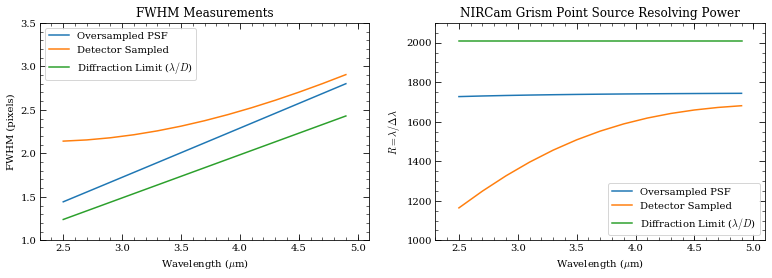

In [13]:
#res = 996.48
#disp = 0.0010035
#res = 1 / disp
res, dw = nrc_utils.grism_res(nrc.pupil,nrc.module)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

#for i in range(len(os_arr)):
#    ax1.plot(waves, fwhm_pix_all[i], label ='Oversample=%i'%(os_arr[i]))
ax1.plot(waves, fwhm_over, label='Oversampled PSF')
ax1.plot(waves, fwhm_det,  label='Detector Sampled')
ax1.plot(waves, fwhm_dif,  label='Diffraction Limit ($\lambda/D$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('FWHM (pixels)')
ax1.set_title('FWHM Measurements')
ax1.legend(loc='best')
ax1.set_xlim([2.3,5.1])
ax1.set_ylim([1.0,3.5])
ax1.minorticks_on()

R_over = waves*res/fwhm_over
R_det = waves*res/fwhm_det
R_dif = waves*res/fwhm_dif

#for i in range(len(os_arr)):
#    d_lambda = fwhm_pix_all[i]
#    ax2.plot(waves, waves*res/d_lambda, label ='Oversample=%i'%(os_arr[i]))
ax2.plot(waves, R_over, label='Oversampled PSF')
ax2.plot(waves, R_det,  label='Detector Sampled')
ax2.plot(waves, R_dif,  label='Diffraction Limit ($\lambda/D$)')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_ylabel('$R=\lambda/\Delta\lambda$')
ax2.set_title('NIRCam Grism Point Source Resolving Power')
ax2.legend(loc='best')
ax2.set_xlim([2.3,5.1])
ax2.set_ylim([1000,2100])
ax2.minorticks_on()

print(R_over.max(),R_det.max(),R_dif.max())

In [14]:
from astropy.table import Table

R_det2  = waves2*res/fwhm_det2
R_over2 = waves2*res/fwhm_over2


data = [waves2, fwhm_det2, fwhm_over2, R_det2, R_over2]
names = ['Wavelength', 'FWHM_det', 'FWHM_over', 'Res_det', 'Res_over']
tbl = Table(data, names=names)

for key in tbl.keys():
    tbl[key].format = '10.3f'
tbl['Wavelength'].format = '3.1f'
print(tbl)

outname = '{}_Mod{}.tbl'.format(nrc.pupil,nrc.module)
tbl.write(outname, format='ascii')

Wavelength  FWHM_det  FWHM_over   Res_det    Res_over 
---------- ---------- ---------- ---------- ----------
       2.0      2.156      1.162    924.244   1715.664
       2.1      2.147      1.218    974.642   1718.451
       2.2      2.141      1.274   1023.996   1720.940
       2.3      2.138      1.330   1072.117   1723.170
       2.4      2.138      1.386   1118.828   1725.174
       2.5      2.140      1.443   1163.971   1726.980
       2.6      2.146      1.499   1207.405   1728.610
       2.7      2.154      1.555   1249.010   1730.085
       2.8      2.165      1.611   1288.686   1731.422
       2.9      2.179      1.668   1326.355   1732.637
       ...        ...        ...        ...        ...
       5.0      2.959      2.857   1683.805   1743.755
       5.1      3.014      2.914   1686.030   1743.957
       5.2      3.071      2.971   1687.547   1744.148
       5.3      3.128      3.028   1688.427   1744.327
       5.4      3.186      3.085   1688.738   1744.497
       5.5

## Unresolved Line Sensitivities

In [15]:
# F_line[W/m^2] = 3e-18 * F_cont[uJy] / (wave[um] * R)
sen_cont_scale = sen_cont / np.sqrt(2.0 / fwhm_det) 
sen_line = 3e-18 * sen_cont_scale / (waves * R_det) 

## Final values

In [16]:
arr = np.array([waves,R_det,sen_cont,sen_line,sat_A0V,sat_M2V]).T
matrix = arr.tolist()
print('{:<7}{:<10}{:<7}{:<10}{:<7}{:<7}'.format('Wave','Res','Fcont','Fline','K_A0V','K_M2V'))
for row in matrix:
    print('{:<7.1f}{:<10.2f}{:<7.2f}{:<10.2e}{:<7.2f}{:<7.2f}'.format(*tuple(row)))


Wave   Res       Fcont  Fline     K_A0V  K_M2V  
2.5    1163.97   10.72  1.14e-20  4.24   4.15   
2.7    1249.01   8.03   7.41e-21  4.39   4.36   
2.9    1326.35   7.18   5.84e-21  4.31   4.30   
3.1    1395.46   7.79   5.68e-21  4.05   4.06   
3.3    1456.09   6.23   4.13e-21  4.11   4.23   
3.5    1508.32   6.12   3.74e-21  3.98   4.20   
3.7    1552.44   6.01   3.42e-21  3.87   4.15   
3.9    1588.95   6.48   3.47e-21  3.65   3.99   
4.1    1618.46   8.35   4.24e-21  3.41   3.72   
4.3    1641.66   9.33   4.53e-21  3.14   3.46   
4.5    1659.30   10.89  5.09e-21  2.87   3.06   
4.7    1672.11   13.80  6.23e-21  2.46   2.71   
4.9    1680.80   18.30  8.03e-21  2.10   2.32   
